In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torch.utils.data as data
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [132]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        
         ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section: mean
        self.encoder_mean = nn.Sequential(
            nn.Linear(3 * 3 * 32, 100),
            nn.ReLU(True),
            nn.Linear(100, latent_dims)
        )
        ### Linear section: std
        self.encoder_std = nn.Sequential(
            nn.Linear(3 * 3 * 32, 100),
            nn.ReLU(True),
            nn.Linear(100, latent_dims)
        )
    
    def forward(self, x):
        ### CNN
        x = self.encoder_cnn(x)        
        x = self.flatten(x)        
        
        ### MLP
        mu = self.encoder_mean(x)  
        sigma = self.encoder_std(x)
        return mu, sigma     

In [190]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        
        ### linear decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 100),
            nn.ReLU(True),
            nn.Linear(100, 3 * 3 * 32),
        )
        
        ### unflatten
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        ### deconcv layer
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, z):
        z = self.decoder_lin(z)
        z = self.unflatten(z)
        z = self.decoder_conv(z)
        z = torch.sigmoid(z)
        return z

In [191]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def reparametrization_trick(self, mu, log_std):
        std = torch.exp(0.5*log_std)
        eps = torch.randn_like(std)
        z = mu +std*eps
        return z
    
    def forward(self, x):
        mu, log_std = self.encoder(x)
        z = self.reparametrization_trick(mu, log_std)
        return self.decoder(z), mu, log_std
    

In [192]:
def train(autoencoder, data, epochs=5):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [194]:
### Load MNIST Dataset
data_train = data.DataLoader(torchvision.datasets.MNIST('./data', train=True,
                    download=True, transform=torchvision.transforms.ToTensor()),
        batch_size=128,
        shuffle=False)

In [211]:
### loss function
def loss_fn(x_hat, x, mu, log_std):
#     rec_loss = F.mse_loss(x_hat, x, reduction='sum')
    rec_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_d = -0.5*torch.sum(1 + log_std - mu**2 - log_std.exp())
    
    return rec_loss + KL_d 

### Training function
def train_epoch(model, device, dataloader, optimizer):
    # Set train mode
    model.train()
    train_loss = 0
    # Iterate the dataloader (we do not need the label values)
    for image_batch, _ in dataloader: 
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        optimizer.zero_grad()
        
        # Code and generate 
        image_rec, mu, log_std = model(image_batch)
        
        # Evaluate loss
        kl = (torch.exp(log_std)**2 + mu**2 - log_std - 1/2).sum()
        loss = ((image_batch - image_rec)**2).sum() + kl
#         loss = loss_fn(image_rec, image_batch, mu, log_std)

        # Backward pass        
        loss.backward()
        
        optimizer.step()
        # Print batch loss
        train_loss += loss.item()
        print('\t partial train loss (single batch): %f' % (loss.item() / len(image_batch)))
    
    print('Average loss: {:.4f}'.format(
          train_loss / len(dataloader.dataset)))
    
    return vae

In [212]:
### Init and Train Model
vae = VariationalAutoencoder(2).to(device) # GPU
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
vae = train_epoch(vae, device, data_train, opt)

	 partial train loss (single batch): 170.281219
	 partial train loss (single batch): 166.799438
	 partial train loss (single batch): 163.882568
	 partial train loss (single batch): 160.908005
	 partial train loss (single batch): 158.485687
	 partial train loss (single batch): 156.832581
	 partial train loss (single batch): 155.279160
	 partial train loss (single batch): 153.189819
	 partial train loss (single batch): 150.793076
	 partial train loss (single batch): 151.166718
	 partial train loss (single batch): 150.504959
	 partial train loss (single batch): 147.351532
	 partial train loss (single batch): 145.402618
	 partial train loss (single batch): 144.134979
	 partial train loss (single batch): 143.832596
	 partial train loss (single batch): 143.459152
	 partial train loss (single batch): 141.629349
	 partial train loss (single batch): 139.709076
	 partial train loss (single batch): 138.445480
	 partial train loss (single batch): 137.465668
	 partial train loss (single batch): 136

	 partial train loss (single batch): 60.314484
	 partial train loss (single batch): 61.325787
	 partial train loss (single batch): 63.321632
	 partial train loss (single batch): 66.491951
	 partial train loss (single batch): 63.865009
	 partial train loss (single batch): 65.505035
	 partial train loss (single batch): 65.430084
	 partial train loss (single batch): 62.182400
	 partial train loss (single batch): 63.476471
	 partial train loss (single batch): 61.100670
	 partial train loss (single batch): 58.139282
	 partial train loss (single batch): 60.705681
	 partial train loss (single batch): 61.300289
	 partial train loss (single batch): 59.987789
	 partial train loss (single batch): 58.720646
	 partial train loss (single batch): 59.573574
	 partial train loss (single batch): 60.962666
	 partial train loss (single batch): 61.929123
	 partial train loss (single batch): 62.139099
	 partial train loss (single batch): 58.323292
	 partial train loss (single batch): 56.539402
	 partial tra

	 partial train loss (single batch): 52.698837
	 partial train loss (single batch): 54.316696
	 partial train loss (single batch): 56.124546
	 partial train loss (single batch): 56.846619
	 partial train loss (single batch): 53.613297
	 partial train loss (single batch): 53.191177
	 partial train loss (single batch): 52.275013
	 partial train loss (single batch): 54.190456
	 partial train loss (single batch): 52.118725
	 partial train loss (single batch): 50.015137
	 partial train loss (single batch): 51.242493
	 partial train loss (single batch): 53.042767
	 partial train loss (single batch): 56.102863
	 partial train loss (single batch): 53.938747
	 partial train loss (single batch): 56.474007
	 partial train loss (single batch): 55.147068
	 partial train loss (single batch): 56.114178
	 partial train loss (single batch): 54.781479
	 partial train loss (single batch): 52.192989
	 partial train loss (single batch): 49.400730
	 partial train loss (single batch): 56.362759
	 partial tra

In [213]:
### Plot Latent space
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        mu, std = autoencoder.encoder(x.to(device))
        z = autoencoder.reparametrization_trick(mu, std)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [214]:
### reconstruct from Random z
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    plt.imshow(img.squeeze(), cmap='gist_gray')
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = 6*torch.rand(1,2).to(device)-3
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

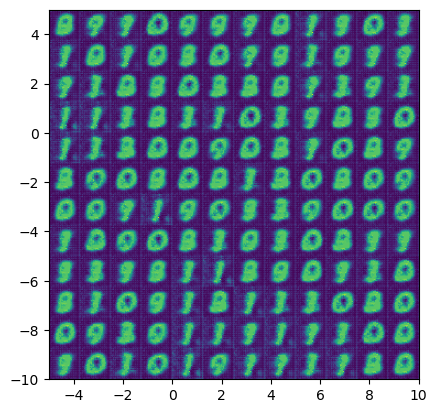

In [215]:
plot_reconstructed(vae)

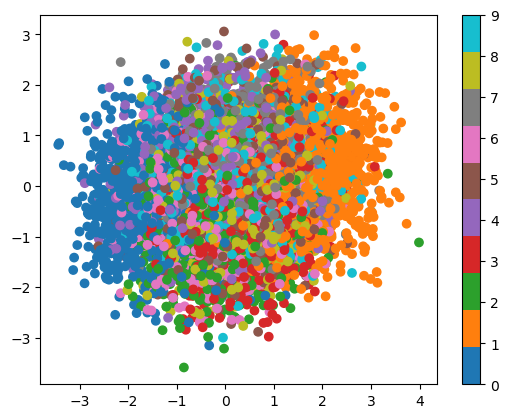

In [216]:
plot_latent(vae, data_train)

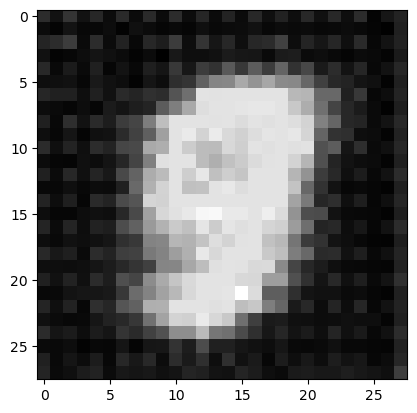

In [218]:
z_rand = torch.rand(1, 2)
x_rec = vae.decoder(z_rand)

for img in x_rec:
    plt.imshow(img.detach().squeeze(), cmap='gist_gray')